In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.transforms import Bbox


In [2]:
df = pd.read_csv("results_full.csv")

metric = "CRPS"
df = df[df["metric"] == metric]
#df = df[df['suite_id'] == 336]

splits = [s for s in df["split_method"].unique() if s.lower() != "random_split"]
 
method_order = [
    'ConstantPredictor', 'LinearRegressor', 'LogisticRegression' , 'RandomForestClassifier', 'RandomForestRegressor', 'LGBMClassifier', 'LGBMRegressor',
    'Engression', 'MLP', 'ResNet', 'FTTransformer', 'DGBT', 'DRF', 'TabPFNRegressor', 'GPBoost_CRPS'
]
rename_map = {
    'RandomForestClassifier': 'Random Forest',
    'RandomForestRegressor': 'Random Forest',
    'LGBMClassifier': 'Boosted Trees',
    'LGBMRegressor': 'Boosted Trees',
    'FTTransformer': 'FT-Transformer',
    'LinearRegressor': 'Linear Regression',
    'TabPFNRegressor': 'TabPFN',
    'GPBoost_CRPS': 'GP'
}

# 3) Extract unique suites, metrics, and extrapolation methods
suites  = df['suite_id'].unique()
metrics = df['metric'].unique()
methods = df['split_method'].unique()

df = df[df["metric"] == "CRPS"]
df = df[df["split_method"] == "random_split"]

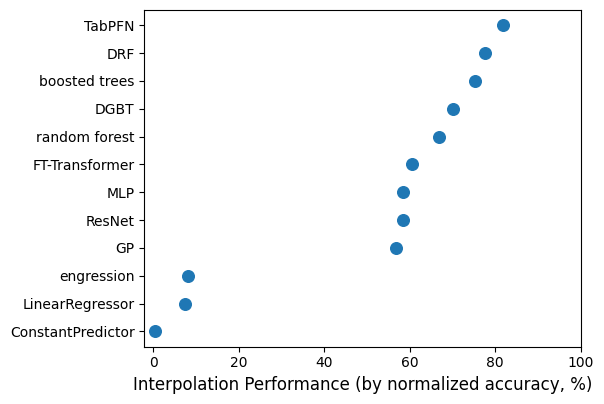

In [4]:
plt.rcParams.update({
    "figure.figsize": (6.2, 4.2),
    "font.size": 12, "axes.labelsize": 12, "axes.titlesize": 12,
    "xtick.labelsize": 10, "ytick.labelsize": 10
})

# helper to get the 3rd‐largest (or worst if <3)
def third_largest(s: pd.Series) -> float:
    vals = s.dropna().nlargest(3)
    return vals.min() if not vals.empty else np.nan

# 1) baseline (best = min error) per split & task
df["baseline"] = (
    df
    .groupby(["split_method", "task_id"])["value"]
    .transform("min")
)

# 2) mid (3rd‐largest error) per split & task
df["mid"] = (
    df
    .groupby(["split_method", "task_id"])["value"]
    .transform(third_largest)
)

# 3) normalized accuracy: (mid – err)/(mid – best), clipped into [0,1]
df["normalized_accuracy"] = (
    (df["mid"] - df["value"])
    / (df["mid"] - df["baseline"])
).clip(0, 1)


overall = (
    df
    .groupby('model')["normalized_accuracy"]
    .mean()
    .reset_index(name='Mean')
)
overall['Mean'] *= 100   # to percent

method_order = [
    'ConstantPredictor','LinearRegressor',
    'RandomForestClassifier','RandomForestRegressor',
    'LGBMClassifier','LGBMRegressor','Engression',
    'MLP','ResNet','FTTransformer','DGBT','DRF', 'TabPFNRegressor', 'GPBoost_CRPS'
]
overall = (
    overall
    .set_index('model')
    .reindex(method_order)
    .reset_index()
)
rename_map = {
    'RandomForestClassifier':'random forest',
    'RandomForestRegressor':'random forest',
    'LGBMClassifier':       'boosted trees',
    'LGBMRegressor':        'boosted trees',
    'Engression':           'engression',
    'MLP':                  'MLP',
    'ResNet':               'ResNet',
    'FTTransformer':        'FT-Transformer',
    'TabPFNRegressor':      'TabPFN',
    'GPBoost_CRPS':        'GP'
}
overall['Method'] = overall['model'].map(rename_map).fillna(overall['model'])

df["Method"] = df["model"].map(rename_map).fillna(df["model"])
stats = (df.groupby("Method")["normalized_accuracy"]
           .agg(mean="mean", std="std", count="count"))
stats["se"] = stats["std"] / np.sqrt(stats["count"]).replace(0, np.nan)
stats = (stats.sort_values("mean", ascending=False) * 100)  # percent

# 4) horizontal dot plot (readable labels, optional error bars)
ypos = np.arange(len(stats))
fig, ax = plt.subplots()
ax.scatter(stats["mean"].values, ypos, s=70)
#ax.errorbar(stats["mean"].values, ypos, xerr=None, fmt="o", ms=6, capsize=3, ls="none")
ax.set_yticks(ypos)
ax.set_yticklabels(stats.index)
ax.invert_yaxis()  # best at top
ax.set_xlabel("Interpolation Performance (by normalized accuracy, %)")
ax.set_ylabel("")
plt.xlim(-2, 100)
ax.grid(False)
plt.tight_layout()

# 5) vector export (crisp in LaTeX)
import os
os.makedirs("PICTURES", exist_ok=True)
plt.savefig("PICTURES/avg_normalized_acc_over_int_CRPS.pdf", bbox_inches="tight")
plt.show()
plt.close()

